# Detectando objetos com YOLO v4 e OpenCV

## Visão geral

No notebook anterior, utilizamos o framework Darknet para realizar a detecção de objetos em imagens com o You only look once (YOLO). Entretanto, também é possível empregar o módulo cv2, que corresponde à implementação do OpenCV em Python, para executar a mesma tarefa, sem a necessidade de compilar (buildar) o framework Darknet.

## Etapa 1 - Importando as bibliotecas

In [1]:
import cv2

print(cv2.__version__)

4.12.0


## Etapa 2 - Conectando com o Google Drive

In [2]:
# Desnecessario

## Etapa 3 - Carregando os arquivos do modelo treinado

In [3]:
import utils

# Obter pesos, configuracao da arquitetura e labels da rede neural do modelo
yolov3 = utils.carregar_yolov3()
yolov3

yolov3(labels_path='/home/rapha/Cursos/opencv-yolo-darknet/shared/modelo_YOLOv3/coco.names', weights_path='/home/rapha/Cursos/opencv-yolo-darknet/shared/modelo_YOLOv3/yolov3.weights', config_path='/home/rapha/Cursos/opencv-yolo-darknet/shared/modelo_YOLOv3/yolov3.cfg', labels=['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell 

In [4]:
# Carregar a rede YOLOv3 no módulo DNN (Deep Neural Network) do OpenCV
net = cv2.dnn.readNet(yolov3.config_path, yolov3.weights_path)
net

< cv2.dnn.Net 0x7f3b05f49b70>

## Etapa 4 - Definindo mais configurações para a detecção

In [5]:
import numpy as np

# Gerar cores RGB aleatorias para "colorir" o contorno da caixa delimitadora de cada label/classe detectada
# NOTE: o OpenCV trabalha com o sistema de cores BGR ao inves do RGB
colors = np.random.randint(0, 255, size=(len(yolov3.labels), 3), dtype='uint8')
colors[:5]

array([[ 14,  24, 212],
       [172, 244,  75],
       [212, 112, 147],
       [240,   8,   9],
       [ 37, 198,  34]], dtype=uint8)

Como é possível ver a seguir, uma rede neural pode ter mais de uma camada de saída, ou seja, camadas que recebem conexões da camada anterior, mas não se conectam a nenhuma camada seguinte.

**ATENÇÃO:** o número de camadas de saída em uma CNN não deve ser confundido com o número de labels (classes) que o modelo é capaz de prever.

In [6]:
# Lista com os identificadores (IDs) de todas as camadas da rede
ln = net.getLayerNames()

# Retorna os índices (baseados em 1) das camadas de saida
ln_saida_indices = net.getUnconnectedOutLayers()

# IDs das camadas de saída
ln_saida_ids = tuple(ln[i - 1] for i in ln_saida_indices)

print('Todas as camadas:', ln)
print('Camadas de saída:', ln_saida_ids)
print('Total de camadas: ' + str(len(ln)))

Todas as camadas: ('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37'

## Etapa 5 - Carregando a imagem onde será feita a detecção

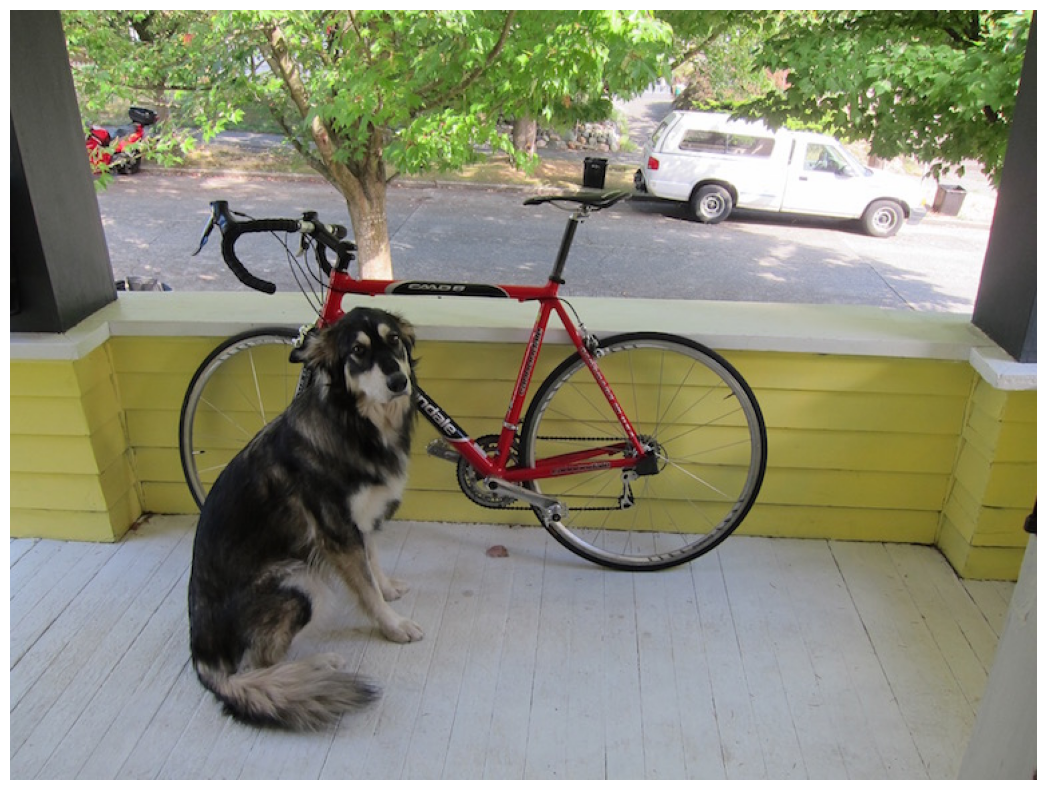

In [ ]:
imagem = utils.mostrar_imagem('dog.jpg')

In [10]:
imagem_cp = imagem.copy()
(H, W) = imagem_cp.shape[:2]
print(f'Dimensoes da imagem: {H} x {W} px')

Dimensoes da imagem: 576 x 768 px


## Etapa 6 - Processando a imagem de entrada

O método blobFromImage aplica duas etapas de processamento na imagem
- Subtração média: resolve problemas de variação de iluminação da imagem, que prejudicaria o processamento dentro da rede neural convolucional
- Redimensionamento da imagem: mudança no tamanho e largura da imagem para se adequar ao tamanho aceito pela CNN 

In [ ]:
import time

# Fator em que a imagem sera redimensionada
fator_escala = 1 / 255.0

# Tamanho da imagem esperado pela CNN
tamanho_esperado_rn = (416, 416)

# Inverter canais RGB (o OpenCV trabalha com BGR)?
trocar_rgb = True

# Cortar imagem para se adequar ao tamanho esperado?
cortar_imagem = False

inicio = time.time()

# Converter imagem para formato de blob
blob = cv2.dnn.blobFromImage(
    image=imagem,
    scalefactor=fator_escala,
    size=tamanho_esperado_rn,
    swapRB=trocar_rgb,
    crop=cortar_imagem,
)
# Enviar imagem para a rede neural
net.setInput(blob=blob)

# Fazer o processamento da rede da entrada para a saida (forward) e obter respostas
layer_outputs = net.forward(ln)

termino = time.time()

print("YOLO levou {:.2f} segundos".format(termino - inicio))

YOLO levou 2.51 segundos
